In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pes_bs_utils import parse_energy_cc, parse_energy_hf,parse_energy
from scipy.interpolate import InterpolatedUnivariateSpline as sp
df_sa_bsc=pd.read_pickle("./df_sa_bsc")
#atoms_path="/home/giorgiod/MRCC_interface/Atoms/"  
basisSets=['sto-3G', 'sto-6G','3-21G','6-31G*','def2-TZVP','def2-QZVPP','cc-pvtz','aug-cc-pVQZ']
atoms="H,He,Li,Be,B,C,N,O,F,Ne,Na,Mg,Al"
atoms=atoms.split(',')

atoms_mol={'HAl':['H','Al'],'HeMg':['He','Mg'],'LiNa':['Li','Na'],\
           'BeNe':['Be','Ne'],'BF':['B','F'],'CO':['C','O'],'NN':['N','N']}
"""def energy(bs,targ,ref,hf=False,mp2=False):
    logfile=atoms_path+'{}/{}/{}_at_{}/run.log'.format(bs,targ,targ,ref)
    if hf:
            return parse_energy_hf(logfile)
    return parse_energy_cc(logfile)"""
def bsc(ref,target):
    return float(df_sa_bsc.query("basis_set=='def2-QZVPP'&ref==@ref&target==@target").bsc )
    """return \
    energy('def2-QZVPP',atoms_mol[target][0],atoms_mol[ref][0])\
    +energy('def2-QZVPP',atoms_mol[target][1],atoms_mol[ref][1]) \
    -energy('def2-QZVPP',atoms_mol[target][0],atoms_mol[target][0])\
    -energy('def2-QZVPP',atoms_mol[target][1],atoms_mol[target][1])"""
bsc('NN','CO')

0.01234583452800564

In [10]:
dt_qzvpp=pd.read_pickle('data_def2_qzvpp')
hfmp2dft=pd.read_pickle('hfmp2dft_def2qzvpp')  #pes at hf, mp2 ,PBE and B3LYP
#hfmp2dft.query("calc=='PBE' & mol=='CO' ").energy-
np.asarray(hfmp2dft.query("calc=='PBE' & mol=='CO' ").energy)-np.asarray(hfmp2dft.query("calc=='MP2' & mol=='CO' ").energy)

array([-0.07659199, -0.07385297, -0.07227073, -0.07132193, -0.07084806,
       -0.07078547, -0.07091321, -0.07108709, -0.07123193, -0.07133677,
       -0.07137496, -0.07132881, -0.07121734, -0.07109933, -0.07112004,
       -0.07155984, -0.07290076, -0.07596497, -0.08207828, -0.09304793])

In [3]:
"""path_atoms_dft="/home/giorgiod/Desktop/MRCC_interface/DFT_BFCONN/Atoms/{}_{}/run.log" #.format(atom,{PBE,B3LYP})
path_atoms_ccsd="/home/giorgiod/Desktop/MRCC_interface/Atoms/def2-QZVPP/{}/{}_at_{}/run.log" #.format(targ,targ,ref) 
parse_energy(path_atoms_ccsd.format("O","O","C"),"ccsd")"""

'path_atoms_dft="/home/giorgiod/Desktop/MRCC_interface/DFT_BFCONN/Atoms/{}_{}/run.log" #.format(atom,{PBE,B3LYP})\npath_atoms_ccsd="/home/giorgiod/Desktop/MRCC_interface/Atoms/def2-QZVPP/{}/{}_at_{}/run.log" #.format(targ,targ,ref) \nparse_energy(path_atoms_ccsd.format("O","O","C"),"ccsd")'

Now we only consider alchemies from NN to CO :: from CO to NN and BF :: from BF to CO <br>
2^nd and 4^th order alchemy VS HF and MP2, true CCSD of the target as a reference.



In [5]:
def atoms_energy(mol,calc,ref="ref"):
    a1,a2=atoms_mol[mol][0],atoms_mol[mol][1]
    if ref != "ref":
        r1,r2=atoms_mol[ref][0],atoms_mol[ref][1]
    if calc=="ccsd" or calc=="HF" or calc=="MP2":
        return parse_energy(path_atoms_ccsd.format(a1,a1,a1),calc)+parse_energy(path_atoms_ccsd.format(a2,a2,a2),calc)
    if calc=="PBE" or calc=="B3LYP":
        return parse_energy(path_atoms_dft.format(a1,calc),calc)+parse_energy(path_atoms_dft.format(a2,calc),calc)
    if calc=="alchemy":
        return parse_energy(path_atoms_ccsd.format(a1,a1,r1),"ccsd")+parse_energy(path_atoms_ccsd.format(a2,a2,r2),"ccsd")

In [6]:
atoms_energy("BF","PBE")

couldn't parse energy return 0 for: /home/giorgiod/Desktop/MRCC_interface/DFT_BFCONN/Atoms/B_PBE/run.log_calc__PBE
couldn't parse energy return 0 for: /home/giorgiod/Desktop/MRCC_interface/DFT_BFCONN/Atoms/F_PBE/run.log_calc__PBE


0

In [7]:
# for masses reference  https://physics.nist.gov/cgi-bin/Compositions/stand_alone.pl
m_B=10.806
m_C=12.0096
m_N=14.006
m_O=15.999
m_F=18.998

# https://physics.nist.gov/cgi-bin/cuu/Value?u|search_for=physchem_in! ++ https://physics.nist.gov/cgi-bin/cuu/Value?me  
dalton_to_au=  1.660e-27 / 9.109e-31

mu_nn=12766.4683422
mu_nn=m_N/2 *dalton_to_au
mu_co=m_C*m_O/(m_C+m_O)*dalton_to_au
mu_bf=m_B*m_F/(m_B+m_F)*dalton_to_au
lightspeed=137.035999753
planck=6.28318530718
centimeter=188972613.392
kcal_mol=627.509
def to_cm(k,Mu):
    return (k/Mu)**0.5*centimeter/planck/lightspeed
print(mu_nn,mu_bf,mu_co)

12762.081457898783 12552.657457934376 12501.650854791682


In [6]:
def sppes(scan):
    points=np.linspace(1.3,3.2,20)
    target_pts=np.linspace (1.3,3.2,1901) # points 20 in 1.3-3.2 (1.9bohrs)
    bspline=sp(points,scan)
    return bspline(target_pts)

In [7]:
#frequencies !!! only for linspace of e-3 bohr  !!!
def freq(spline,mol):
    red_masses={'NN':mu_nn,'CO':mu_co,'BF':mu_bf}
    Mu=red_masses[mol]
    min_true=np.argmin(spline)
    k_true=(spline[min_true-1]+spline[min_true+1]-2*spline[min_true])*1.e+6
    return to_cm(k_true,Mu)

In [8]:
#This was for seminar _ cancel line for NC

def Plot(ax,ref,target):
    target_pts=np.linspace (1.3,3.2,1901)
    spline_ccsd=sppes(dt_qzvpp.query("alchemy==0 &ref==@ref & target==@target").e_ccsd)-atoms_energy(target,"ccsd")
    spline_alch2=sppes(dt_qzvpp.query("alchemy==2 &ref==@ref & target==@target").e_alch)-atoms_energy(target,"alchemy",ref=ref)
    spline_alch4=sppes(dt_qzvpp.query("alchemy==4 &ref==@ref & target==@target").e_alch)-atoms_energy(target,"alchemy",ref=ref)
    spline_alch4_NC=sppes(dt_qzvpp.query("alchemy==4 &ref==@ref & target==@target").e_alch)-atoms_energy(target,"ccsd")
    spline_hf=sppes(hfmp2dft.query("calc=='HF' & mol==@target").energy)-atoms_energy(target,"HF")
    spline_mp2=sppes(hfmp2dft.query("calc=='MP2' & mol==@target").energy)-atoms_energy(target,"MP2")
    spline_pbe=sppes(hfmp2dft.query("calc=='PBE' & mol==@target").energy)-atoms_energy(target,"PBE")
    spline_b3lyp=sppes(hfmp2dft.query("calc=='B3LYP' & mol==@target").energy)-atoms_energy(target,"B3LYP")
    
    ax[0].plot(target_pts,spline_ccsd*kcal_mol,label='CCSD',color='C0',lw=3.)
    ax[0].plot(target_pts,spline_alch4*kcal_mol,label='With correction ',color='C1',lw=3.,ls='-.' )
    ax[0].plot(target_pts,spline_mp2*kcal_mol,label="MP2",color='C2',lw=3.,ls='--')
    ax[0].plot(target_pts,spline_pbe*kcal_mol,label='PBE',color='C3',lw=3.,ls=':')
    ax[0].plot(target_pts,spline_b3lyp*kcal_mol,label='B3LYP',color='C4',lw=3.,ls=':')
    ax[0].plot(target_pts,spline_alch4_NC*kcal_mol,label='Alchemy $4^{th}$ ',color='C5',lw=3.,ls='-.' )
    
# [ '-' | '--' | '-.' | ':' | 'steps' | ...]

    minim=min([min(spline_alch4),min(spline_mp2),min(spline_alch4),min(spline_pbe),min(spline_b3lyp)])
    ax[0].set(xlim=(1.8,2.6),ylim=(minim*kcal_mol-5, minim*kcal_mol+60 ))

    ax[1].bar(0,freq(spline_ccsd,target),color='C0',label='CCSD')
    ax[1].bar(1,freq(spline_alch4,target),color='C1',label='Alchemy $4^{th}$')
    ax[1].bar(2,freq(spline_mp2,target),color='C2',label='MP2')    
    ax[1].bar(3,freq(spline_pbe,target),color='C3',label='PBE')    
    ax[1].bar(4,freq(spline_b3lyp,target),color='C4',label="B3LYP")    
    

C:\Users\zorzo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
C:\Users\zorzo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
C:\Users\zorzo\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes curre

NameError: name 'atoms_energy' is not defined

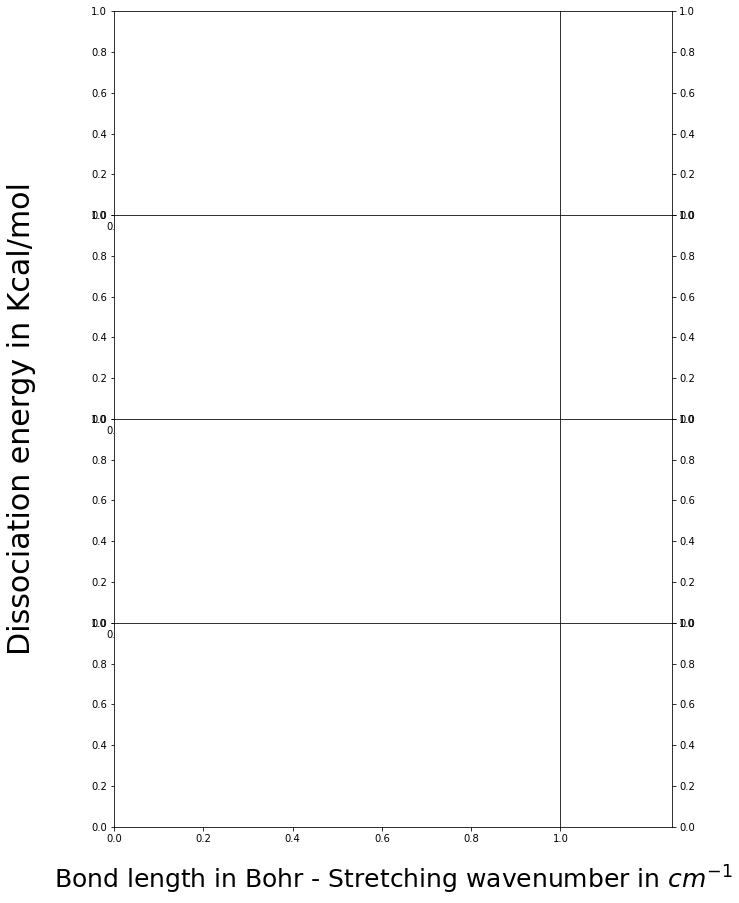

In [11]:
fig=plt.figure(figsize=(10,15))

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.axes().set_ylabel("Dissociation energy in Kcal/mol",fontsize=30,labelpad=55)
plt.axes().set_xlabel(r'Bond length in Bohr - Stretching wavenumber in $cm^{-1}$',fontsize=25,labelpad=20)
plt.axes().set_frame_on(False)


subplspec={'width_ratios' :[4,1], 'wspace':0,'hspace':0}
axs=fig.subplots(4,2,gridspec_kw=subplspec)


for ax in axs.T[:][1]: ax.yaxis.tick_right(),ax.xaxis.set_ticks([])
Plot(axs[0],'CO','NN')
Plot(axs[1],'NN','CO')
Plot(axs[2],'BF','CO')
Plot(axs[3],'CO','BF')
axs[0][0].xaxis.set_ticks([]),axs[1][0].xaxis.set_ticks([]),axs[2][0].xaxis.set_ticks([])

#axs[0][0].yaxis.set_ticks([]),axs[1][0].yaxis.set_ticks([]),axs[2][0].yaxis.set_ticks([])

axs[0][1].set(ylim=(2050,2800)),axs[1][1].set(ylim=(2050,2500)),axs[2][1].set(ylim=(2050,2500)),axs[3][1].set(ylim=(1200,1600))

for ax in axs:
    for axg in ax:
        axg.tick_params(labelsize=25)
        axg.yaxis.set_ticks(axg.get_yticks()[1:-1])
        
box_prop=dict(boxstyle='round', facecolor='white', alpha=1.)
axs[0][0].text(2.0,-194, r'CO $\rightarrow$ NN',fontsize=25,bbox=box_prop)
axs[1][0].text(2.0,-220, r'NN $\rightarrow$ CO',fontsize=25,bbox=box_prop)
axs[2][0].text(2.0,-220, r'BF $\rightarrow$ CO',fontsize=25,bbox=box_prop)
axs[3][0].text(2.3,-140, r'CO $\rightarrow$ BF',fontsize=25,bbox=box_prop)

#axs[0][1].legend(ncol=3,bbox_to_anchor=(0.25,1.21,.8,.2),fontsize=20,markerscale=.05)
axs[0][0].legend(ncol=3,fontsize=20,bbox_to_anchor=(0.3,1.1,.8,.2))
plt.savefig('freq_PhD_sem.png',bbox_inches="tight",dpi=150)

In [ ]:
"""subplspec={'width_ratios' :[4,1], 'wspace':0,'hspace':0}
fig,axs=plt.subplots(4,2,figsize=(10,15),gridspec_kw=subplspec)
for ax in axs.T[:][1]: ax.yaxis.tick_right()
Plot(axs[0],'CO','NN')
Plot(axs[1],'BF','NN')
Plot(axs[2],'NN','CO')
Plot(axs[3],'BF','CO')
Plot(axs[4],'CO','BF')
Plot(axs[5],'NN','BF')
plt.savefig('freq_2.png') """

In [ ]:
"""def Plot(ax,ref,target):
    target_pts=np.linspace (1.3,3.2,1901)
    spline_ccsd=sppes(dt_qzvpp.query("alchemy==0 &ref==@ref & target==@target").e_ccsd )
    spline_alch2=sppes(dt_qzvpp.query("alchemy==2 &ref==@ref & target==@target").e_alch )-bsc('NN','CO')
    spline_alch4_noc=sppes(dt_qzvpp.query("alchemy==4 &ref==@ref & target==@target ").e_alch )
    spline_alch4=sppes(dt_qzvpp.query("alchemy==4 &ref==@ref & target==@target").e_alch )-bsc('NN','CO')
    spline_hf=sppes(hfmp2dft.query("calc=='HF' & mol==@target").energy)
    spline_mp2=sppes(hfmp2dft.query("calc=='MP2' & mol==@target").energy)
    spline_pbe=sppes(hfmp2dft.query("calc=='PBE' & mol==@target").energy)
    spline_b3lyp=sppes(hfmp2dft.query("calc=='B3LYP' & mol==@target").energy)
    """

In [ ]:
def Plot2(ax,ref,target):
    target_pts=np.linspace (1.3,3.2,1901)
    spline_ccsd=sppes(dt_qzvpp.query("alchemy==0 &ref==@ref & target==@target").e_ccsd)
    spline_alch2=sppes(dt_qzvpp.query("alchemy==2 &ref==@ref & target==@target").e_alch)-bsc(ref,target)
    spline_alch4_noc=sppes(dt_qzvpp.query("alchemy==4 &ref==@ref & target==@target").e_alch)
    spline_alch4=sppes(dt_qzvpp.query("alchemy==4 &ref==@ref & target==@target").e_alch)-bsc(ref,target)
    spline_hf=sppes(hfmp2dft.query("calc=='HF' & mol==@target").energy)
    spline_mp2=sppes(hfmp2dft.query("calc=='MP2' & mol==@target").energy)
    spline_pbe=sppes(hfmp2dft.query("calc=='PBE' & mol==@target").energy)
    spline_b3lyp=sppes(hfmp2dft.query("calc=='B3LYP' & mol==@target").energy)
    
    ax[0].plot(target_pts,spline_ccsd,label='CCSD',color='C0')
    ax[0].plot(target_pts,spline_alch2,label='Alchemy $2^{nd}$ order',color='C1')
    ax[0].plot(target_pts,spline_alch4_noc,':',label='Alchemy $4^{nd}$ order no C',color='C2')
    ax[0].plot(target_pts,spline_alch4,label='Alchemy $4^{th}$ order',color='C3')
    ax[0].plot(target_pts,spline_hf,label="HF",color='C4')
    ax[0].plot(target_pts,spline_mp2,label="MP2",color='C5')
    ax[0].plot(target_pts,spline_pbe,label='PBE',color='C6')
    ax[0].plot(target_pts,spline_b3lyp,label='B3LYP',color='C7')
        
    ax[0].set(xlim=(1.8,2.6),ylim=(min(spline_b3lyp)-.005, spline_alch4_noc[np.argmin(spline_ccsd)-300]))

    ax[1].bar(0,freq(spline_ccsd,target),color='C0',label='CCSD')
    ax[1].bar(1,freq(spline_alch2,target),color='C1',label='Alchemy $2^{nd}$ order')
    ax[1].bar(2,freq(spline_alch4,target),color='C3',label='Alchemy $4^{th}$ order')
    ax[1].bar(3,freq(spline_hf,target),color='C4',label='HF')
    ax[1].bar(4,freq(spline_mp2,target),color='C5',label='MP2')    
    ax[1].bar(5,freq(spline_pbe,target),color='C6',label='PBE')    
    ax[1].bar(6,freq(spline_b3lyp,target),color='C7',label="B3LYP")    
    